In [13]:
%pip install yfinance tensorflow matplotlib scikit-learn ta

Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
aiofiles                     23.2.1
altair                       5.5.0
annotated-types              0.7.0
anyio                        4.8.0
asttokens                    3.0.0
astunparse                   1.6.3
attrs                        25.1.0
backcall                     0.2.0
beautifulsoup4               4.13.3
blinker                      1.9.0
Brotli                       1.0.9
cachetools                   5.5.2
certifi                      2025.1.31
charset-normalizer           3.3.2
click                        8.1.8
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.11
decorator                    5.2.1
exceptiongroup               1.2.2
executing                    2.1.0
fastapi                      0.115.8
ffmpy                        0.5.0
f

In [1]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Step 1: Load the Stock Data


In [3]:
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

ImportError: cannot import name 'mean_squared_error' from 'tensorflow.keras.losses' (c:\Users\shubh\.conda\envs\stock\lib\site-packages\keras\_tf_keras\keras\losses\__init__.py)

In [7]:
import yfinance as yf
import ta
import pandas as pd

def load_stock_data(ticker, start_date, end_date):
    # Fetch stock data
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    
    # Reset index for proper datetime handling
    data.reset_index(inplace=True)
    
    # Ensure 'Adj Close' is a 1D Series
    adj_close = data['Adj Close'].squeeze()
    
    # Compute percentage return
    data['Return'] = adj_close.pct_change()

    # Compute Technical Indicators
    data['RSI'] = ta.momentum.RSIIndicator(adj_close).rsi()
    data['EMA'] = ta.trend.EMAIndicator(adj_close).ema_indicator()
    data['ATR'] = ta.volatility.AverageTrueRange(
        high=data['High'].squeeze(), 
        low=data['Low'].squeeze(), 
        close=adj_close
    ).average_true_range()
    
    data['VWAP'] = ta.volume.VolumeWeightedAveragePrice(
        high=data['High'].squeeze(), 
        low=data['Low'].squeeze(), 
        close=adj_close, 
        volume=data['Volume'].squeeze()
    ).volume_weighted_average_price()

    # Drop NaN values that appear due to indicator calculations
    data.dropna(inplace=True)

    return data


[*********************100%***********************]  1 of 1 completed

Price        Date  Adj Close      Close       High        Low       Open  \
Ticker                 GOOGL      GOOGL      GOOGL      GOOGL      GOOGL   
13     2018-01-22  57.997753  58.208000  58.344002  57.091000  57.191002   
14     2018-01-23  58.596081  58.808498  58.925499  58.362499  58.530998   
15     2018-01-24  58.352962  58.564499  59.352501  58.369999  59.249001   
16     2018-01-25  58.893505  59.106998  59.250000  58.591999  59.035500   
17     2018-01-26  59.163525  59.377998  59.377998  58.401501  59.376499   

Price     Volume    Return        RSI        EMA       ATR       VWAP  
Ticker     GOOGL                                                       
13      29550000  0.018067  92.958751  55.945507  0.877265  55.784887  
14      39138000  0.010316  94.032528  56.298917  0.880871  56.246304  
15      37128000 -0.004149  88.150180  56.572789  0.888130  56.610761  
16      29984000  0.009263  89.693886  56.882218  0.888767  56.884106  
17      42170000  0.004585  90.3688

<Figure size 1200x600 with 0 Axes>

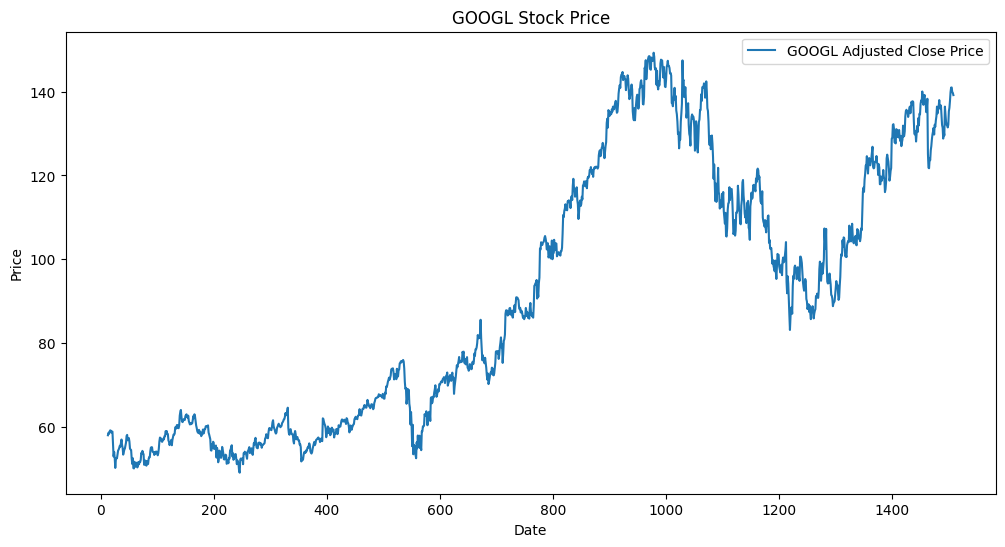

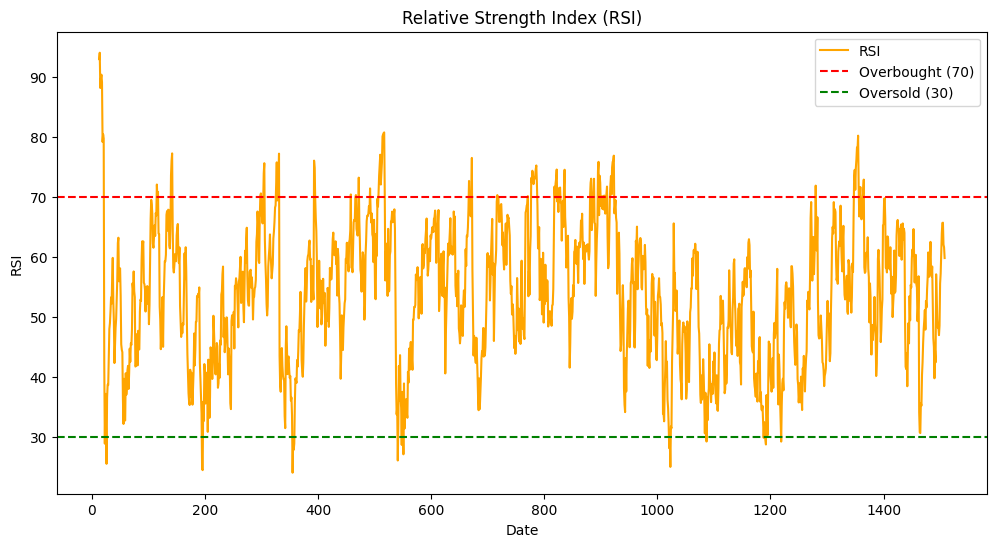

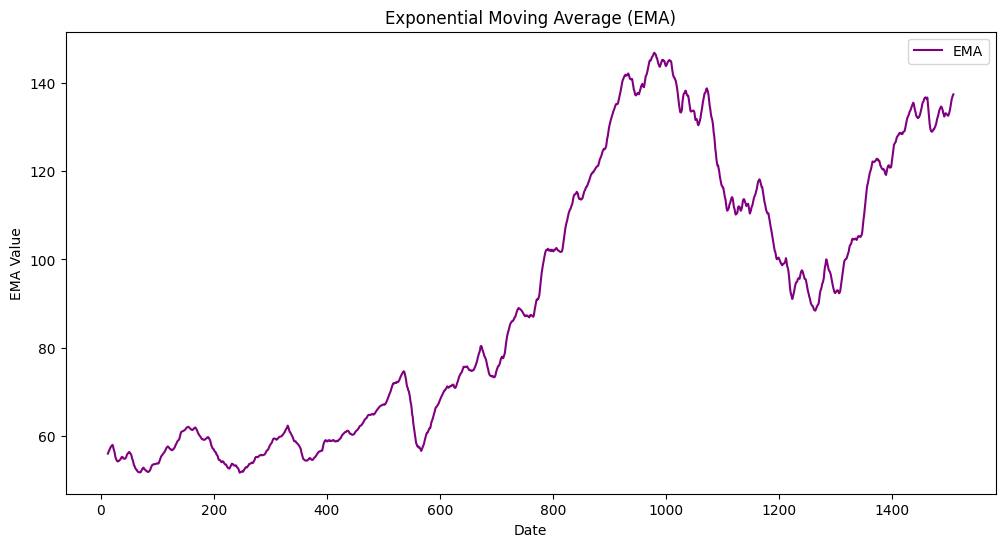

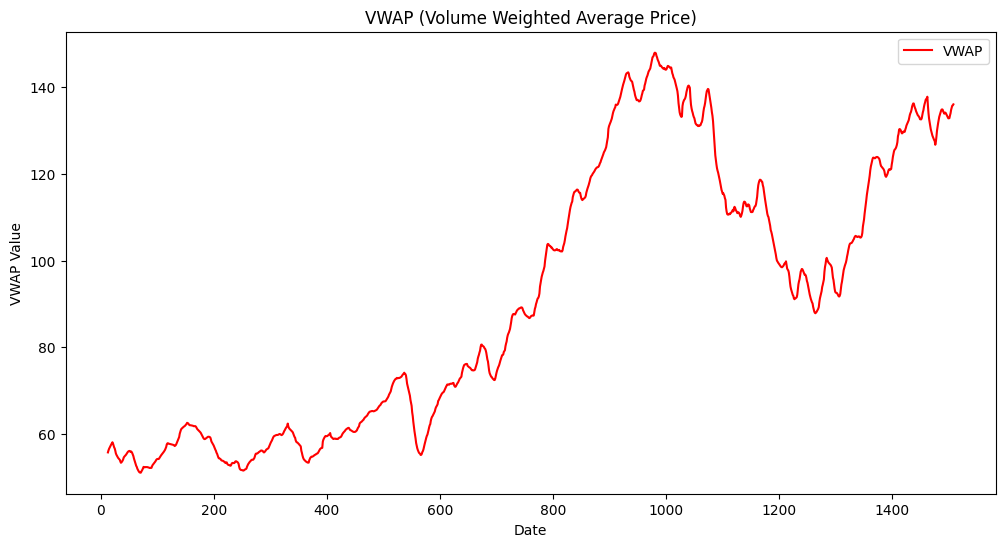

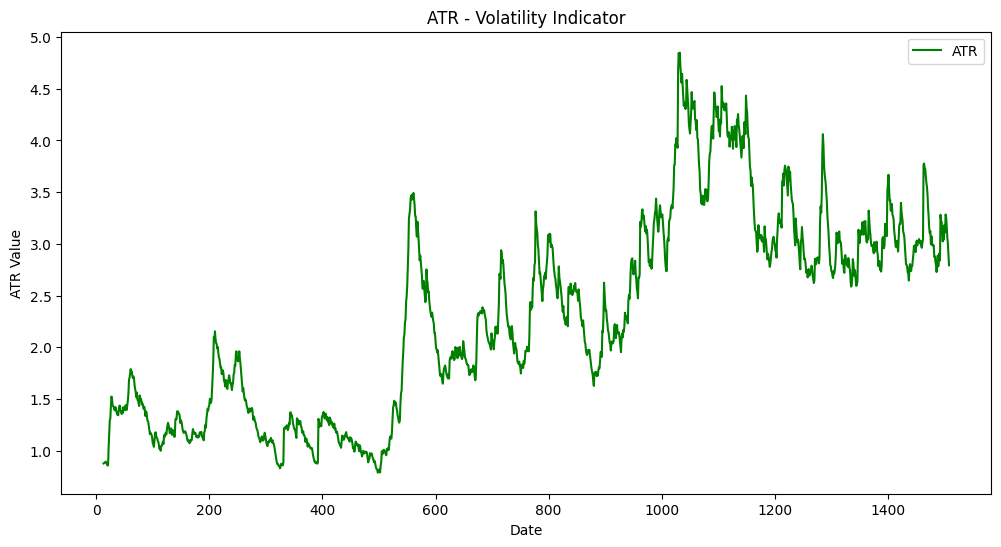

In [8]:
# User Inputs
stock_symbol = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-12-31"

data = load_stock_data(stock_symbol, start_date, end_date)
print(data.head())

import matplotlib.pyplot as plt

# Adjust figure size
plt.figure(figsize=(12, 6))

# 1️⃣ Plot Adjusted Close Price
plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'], label=f"{stock_symbol} Adjusted Close Price")
plt.title(f"{stock_symbol} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# 2️⃣ Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(data['RSI'], label='RSI', color='orange')
plt.axhline(y=70, color='r', linestyle='--', label="Overbought (70)")
plt.axhline(y=30, color='g', linestyle='--', label="Oversold (30)")
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.show()

# 3️⃣ Plot EMA
plt.figure(figsize=(12, 6))
plt.plot(data['EMA'], label='EMA', color='purple')
plt.title("Exponential Moving Average (EMA)")
plt.xlabel("Date")
plt.ylabel("EMA Value")
plt.legend()
plt.show()

# 4️⃣ Plot VWAP (Volume Weighted Average Price)
plt.figure(figsize=(12, 6))
plt.plot(data['VWAP'], label='VWAP', color='red')
plt.title("VWAP (Volume Weighted Average Price)")
plt.xlabel("Date")
plt.ylabel("VWAP Value")
plt.legend()
plt.show()

# 5️⃣ Plot ATR (Volatility Indicator)
plt.figure(figsize=(12, 6))
plt.plot(data['ATR'], label='ATR', color='green')
plt.title("ATR - Volatility Indicator")
plt.xlabel("Date")
plt.ylabel("ATR Value")
plt.legend()
plt.show()


In [ ]:
# Step 3: Prepare the Dataset
features = ['Adj Close', 'Volume', 'RSI', 'EMA','VWAP','ATR']
lookback = 7  # Total number of days window choosen

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, 0])  # Target is the first column: 'Adj Close'
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback)

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Input
from tensorflow.keras.optimizers import Adam


In [21]:
from tensorflow.keras.layers import Attention, Input

input_layer = Input(shape=(lookback, len(features)))
lstm_out = LSTM(100, return_sequences=True)(input_layer)
attention = Attention()([lstm_out, lstm_out])
lstm_out2 = LSTM(50, return_sequences=False)(attention)
output = Dense(1)(lstm_out2)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 100)    │     42,800 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 7, 100)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     30,200 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         51 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,051 (285.36 KB)

 Trainable params: 73,051 (285.36 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# # Step 4: Build the LSTM Model
# import tensorflow as tf
# model = Sequential([
#     LSTM(128, activation='relu', return_sequences=True, input_shape=(lookback, len(features))),
#     Dropout(0.3),
#     LSTM(64, activation='relu', return_sequences=True),
#     BatchNormalization(),
# #     BatchNormalization(),
#     LSTM(32, activation='relu', return_sequences=False),
#     Dropout(0.2),
#     Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
# ])


# model.compile(optimizer='adam', loss='mse')
# model.summary()

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0657 - val_loss: 0.0035
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9449e-04 - val_loss: 0.0022
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6794e-04 - val_loss: 0.0021
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4711e-04 - val_loss: 0.0019
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1970e-04 - val_loss: 0.0020
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6014e-04 - val_loss: 0.0019
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2770e-04 - val_loss: 0.0019
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4814e-04 - val_loss: 0.0020
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7080e-04 - val_loss: 0.0023
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

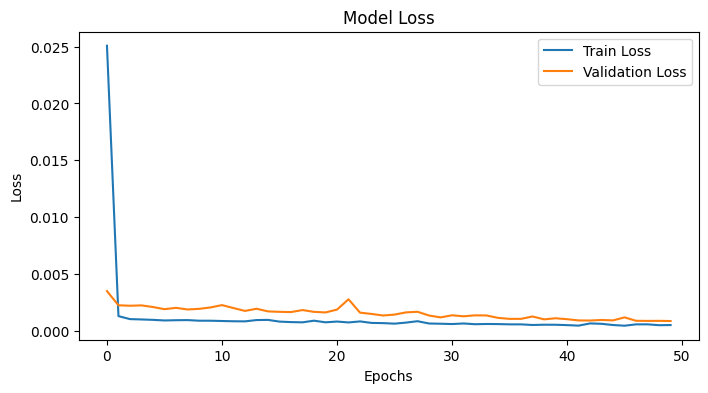

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


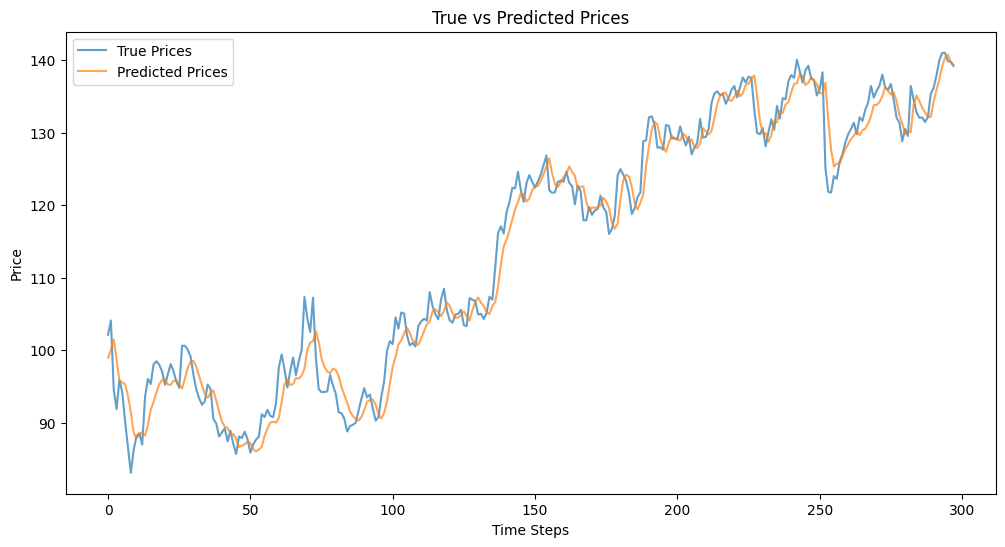

In [22]:


# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the Model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot Training History
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 7: Make Predictions
y_pred = model.predict(X_test)

# Rescale predictions and actual values
def rescale(data, predictions):
    dummy_features = np.zeros((len(predictions), len(features) - 1))
    rescaled = scaler.inverse_transform(np.concatenate([predictions, dummy_features], axis=1))
    return rescaled[:, 0]

y_pred_rescaled = rescale(data[features], y_pred)
y_test_rescaled = rescale(data[features], y_test.reshape(-1, 1))

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="True Prices", alpha=0.7)
plt.plot(y_pred_rescaled, label="Predicted Prices", alpha=0.7)
plt.title("True vs Predicted Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


In [23]:
model.save('FeaturesAddedGoogleAttentionModel.keras')
print("Model saved as lstm_stock_model - Apple stock price")

Model saved as lstm_stock_model - Apple stock price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\shubh\AppData\Local\Temp\ipykernel_57504\4183492561.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  today_price = float(data['Adj Close'].iloc[-1])
2025-02-27 13:26:38.861 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 13:26:39.777 
  command:

    streamlit run c:\Users\shubh\.conda\envs\stock\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-27 13:26:39.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 13:26:39.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 13:26:39.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 13:26:39.784 Thread 

NameError: name 'test_dates' is not defined

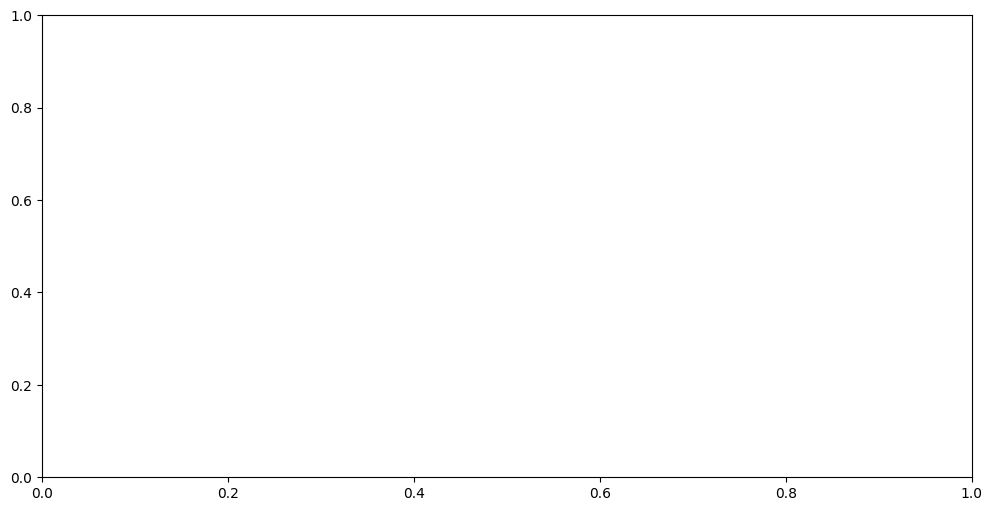

In [ ]:
import streamlit as st
latest_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Latest sequence
predicted_scaled = model.predict(latest_data)

dummy_features = np.zeros((predicted_scaled.shape[0], len(features) - 1))
predicted_price = scaler.inverse_transform(np.concatenate([predicted_scaled, dummy_features], axis=1))[:, 0]

today_price = float(data['Adj Close'].iloc[-1])
# today_price= float(data["Adj Close"].)
tomorrow_price = predicted_price[0]

# Display Tomorrow's Prediction
st.write(f"📈 **Tomorrow's Predicted Price: {tomorrow_price:.2f}** (Today: {today_price:.2f})")

# Trading Decision
if tomorrow_price > today_price:
    st.success(f"✅ **BUY Signal:** Expected Price Increase from {today_price:.2f} to {tomorrow_price:.2f}")
else:
    st.warning(f"❌ **NO BUY:** Expected Price Drop from {today_price:.2f} to {tomorrow_price:.2f}")

# **Plot True vs Predicted Prices**
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates, y_test_rescaled, label="Actual Prices", linestyle="solid", alpha=0.7, color="blue")
ax.plot(test_dates, y_pred_rescaled, label="Predicted Prices", linestyle="dashed", color="red", alpha=0.7)
ax.set_title(f"True vs Predicted Prices for {stock_symbol} (2024)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.xticks(rotation=45)
st.pyplot(fig)

# Show Prediction Results
st.write(f"📌 **Predicted Prices for {stock_symbol} (Last 5 Days):**")
predictions_df = pd.DataFrame({"Date": test_dates[-5:], "Predicted Price": y_pred_rescaled[-5:]})
st.write(predictions_df)